In [77]:
import numpy as np 
import scipy as sp 
import scipy.sparse as spsp 
import scipy.sparse.linalg as spsplin

## Partie 1. (GMRES)

1. 

In [78]:
def Arnoldi(A, V, H):
    n, p = V.shape
    v = V[:, -1]  # 取出 v_{p-1}
    w = A @ v  # 计算 w_p = A v_{p-1}
    h = np.zeros(p + 1)  # 存储新的 h 列

    # 正交化
    for j in range(p):
        h[j] = np.dot(V[:, j], w)  # 计算 h_{j,p-1}
        w = w - h[j] * V[:, j]

    h[p] = np.linalg.norm(w)  # 计算 h_{p,p-1}

    if h[p] == 0:
        # Arnoldi过程失败，返回当前的 V 和 H
        print("Arnoldi process breaks down at iteration", p)
        return V, H

    v_new = w / h[p]  # 计算新的基向量 v_p

    V_new = np.hstack((V, v_new.reshape(-1, 1)))  # 更新 V 矩阵

    # 更新 H 矩阵
    H_new = np.zeros((p + 1, p))  # H 矩阵的形状是 (p+1, p)
    if H.size == 0:
        # 如果 H 是空的，直接设置第一列
        H_new[:, 0] = h
    else:
        # 复制旧的 H 矩阵
        H_new[:-1, :-1] = H
        # 设置最后一列
        H_new[:, -1] = h

    return V_new, H_new

2. 

In [79]:
def gmres(A, b, xexact, max_iter=100, tol=1e-6):
    n = len(b)
    x0 = np.zeros(n)
    r0 = b - A @ x0
    beta = np.linalg.norm(r0)
    v0 = r0 / beta
    V = v0.reshape(-1, 1)
    H = np.zeros((1, 0))  # 修改初始化

    errors = []
    residuals = []

    for k in range(max_iter):
        # 扩展 Krylov 子空间
        V, H = Arnoldi(A, V, H)
        m = H.shape[0]
        # 构造最小二乘问题
        e1 = np.zeros(m)
        e1[0] = beta
        # 进行 QR 分解
        Q, R = np.linalg.qr(H)
        # 计算 y
        y = np.linalg.solve(R, Q.T @ e1)
        # 更新解
        xk = x0 + V[:, :-1] @ y
        # 计算误差和残差
        error = np.linalg.norm(xexact - xk) / np.linalg.norm(xexact)
        rk = b - A @ xk
        residual = np.linalg.norm(rk) / np.linalg.norm(r0)
        errors.append(error)
        residuals.append(residual)
        # 检查收敛
        if residual < tol:
            print(f"GMRES converged at iteration {k+1}")
            break
    return xk, errors, residuals


3. 

In [80]:
# 生成矩阵和向量
n = 100  # 选择合适的矩阵大小
A = np.diag(2 * np.ones(n)) + 0.5 * np.random.rand(n, n) / np.sqrt(n)
b = np.random.rand(n)

# 计算精确解
xexact = np.linalg.solve(A, b)

# 运行 GMRES 算法
xk, errors, residuals = gmres(A, b, xexact, max_iter=50, tol=1e-8)

GMRES converged at iteration 8


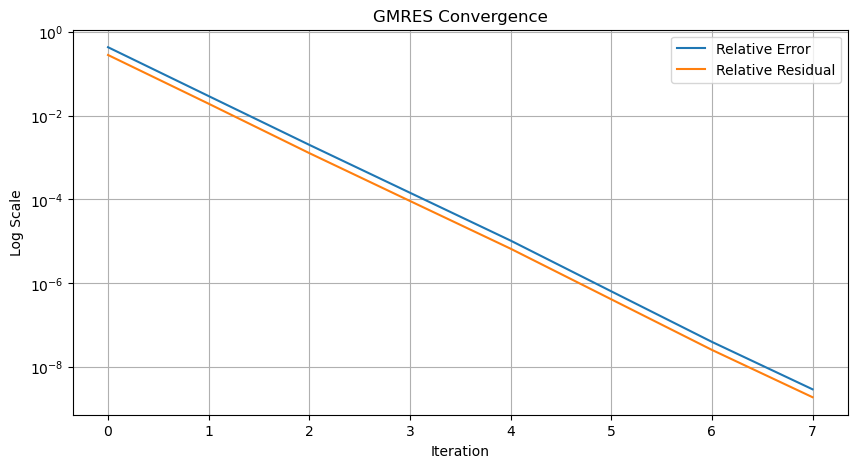

In [81]:
# 绘制误差和残差

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.semilogy(errors, label='Relative Error')
plt.semilogy(residuals, label='Relative Residual')
plt.xlabel('Iteration')
plt.ylabel('Log Scale')
plt.title('GMRES Convergence')
plt.legend()
plt.grid(True)
plt.show()

4. 

In [82]:
def gmres_restart(A, b, xexact, restart=10, max_iter=100, tol=1e-6):
    n = len(b)
    x = np.zeros(n)
    errors = []
    residuals = []
    total_iter = 0
    r = b - A @ x
    beta = np.linalg.norm(r)

    while total_iter < max_iter and beta > tol * np.linalg.norm(b):
        V = (r / beta).reshape(-1,1)
        H = np.zeros((0,0))
        for k in range(restart):
            total_iter += 1
            V, H = Arnoldi(A, V, H)
            m = H.shape[0]
            e1 = np.zeros((m, 1))
            e1[0] = beta
            Q, R = np.linalg.qr(H)
            y = np.linalg.solve(R, Q.T @ e1)
            x_new = x + V[:, :-1] @ y.flatten()
            # 计算误差和残差
            error = np.linalg.norm(xexact - x_new) / np.linalg.norm(xexact)
            rk = b - A @ x_new
            residual = np.linalg.norm(rk) / np.linalg.norm(b)
            errors.append(error)
            residuals.append(residual)
            # 检查收敛
            if residual < tol:
                print(f"GMRES with restart converged at iteration {total_iter}")
                return x_new, errors, residuals
        # 更新 x 和 r，准备下一次重启
        x = x_new
        r = b - A @ x
        beta = np.linalg.norm(r)
    return x, errors, residuals

In [ ]:
def gmres(A, b, xexact, p, max_iter=1000, tol=1e-6):
    """
    实现具有重启功能的 GMRES 算法，每 p 次迭代后重启。

    参数：
    A : ndarray
        系数矩阵，形状为 (n, n)。
    b : ndarray
        右端项向量，形状为 (n,)。
    xexact : ndarray
        方程的精确解（用于计算误差），形状为 (n,)。
    p : int
        重启周期，每进行 p 次迭代后重启算法。
    max_iter : int, 可选
        最大迭代次数，默认为 1000。
    tol : float, 可选
        收敛判据的容差，默认为 1e-6。

    返回：
    xk : ndarray
        近似解，形状为 (n,)。
    errors : list
        每次迭代的相对误差列表。
    residuals : list
        每次迭代的残差范数列表。
    """
    n = len(b)
    x0 = np.zeros(n)  # 初始猜测
    errors = []
    residuals = []
    total_iter = 0    # 总的迭代次数

    r0 = b - A @ x0
    beta = np.linalg.norm(r0)
    residual = beta / np.linalg.norm(b)
    residuals.append(residual)
    error = np.linalg.norm(xexact - x0) / np.linalg.norm(xexact)
    errors.append(error)

    while residual > tol and total_iter < max_iter:
        # 初始化 Krylov 子空间的基向量矩阵和 Hessenberg 矩阵
        V = (r0 / beta).reshape(-1, 1)  # v0
        H = np.zeros((1, 0))            # 初始为空

        for k in range(p):
            V, H = Arnoldi(A, V, H)
            m = H.shape[0]
            e1 = np.zeros(m)
            e1[0] = beta

            # 解最小二乘问题以得到 y
            y, _ = sp.linalg.lstsq(H, e1)[:2]

            # 更新近似解
            xk = x0 + V[:, :-1] @ y

            # 计算新的残差和误差
            rk = b - A @ xk
            residual = np.linalg.norm(rk) / np.linalg.norm(b)
            error = np.linalg.norm(xexact - xk) / np.linalg.norm(xexact)

            errors.append(error)
            residuals.append(residual)
            total_iter += 1

            # 检查收敛条件
            if residual < tol or total_iter >= max_iter:
                print(f"GMRES converges at {total_iter}th iteration")
                return xk, errors, residuals

        # 重启：更新初始猜测和残差
        x0 = xk
        r0 = b - A @ x0
        beta = np.linalg.norm(r0)
        residual = beta / np.linalg.norm(b)
        errors.append(np.linalg.norm(xexact - x0) / np.linalg.norm(xexact))
        residuals.append(residual)

    print(f"GMRES did not converge after reaching the maximum number of iterations {max_iter}")
    return xk, errors, residuals

测试

GMRES with restart converged at iteration 8


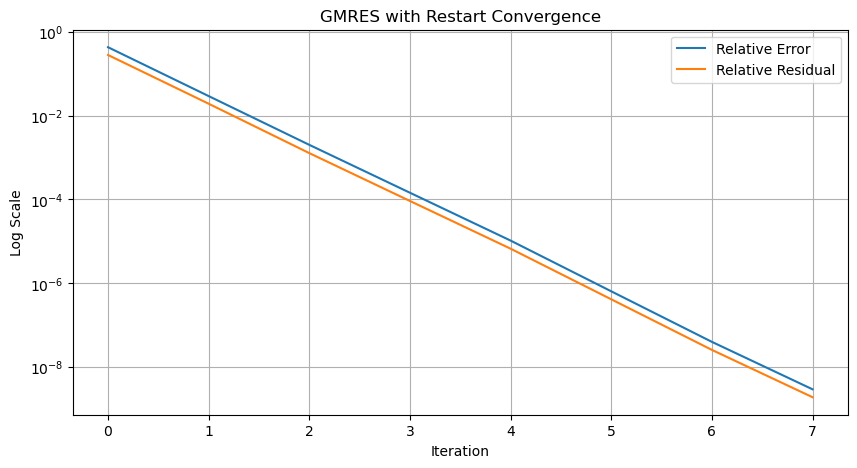

In [83]:
xk, errors, residuals = gmres_restart(A, b, xexact, restart=10, max_iter=100, tol=1e-8)

# 绘制误差和残差
plt.figure(figsize=(10,5))
plt.semilogy(errors, label='Relative Error')
plt.semilogy(residuals, label='Relative Residual')
plt.xlabel('Iteration')
plt.ylabel('Log Scale')
plt.title('GMRES with Restart Convergence')
plt.legend()
plt.grid(True)
plt.show()

## Partie 2. (Gradient Conjugué) 

5. 

In [84]:
def gradient_conjugue(A, b, xexact, max_iter=1000, tol=1e-8):
    n = len(b)
    x = np.zeros(n)
    r = b - A @ x
    d = r.copy()
    errors = []
    residuals = []
    r_norm = np.dot(r, r)
    initial_r_norm = r_norm

    for k in range(max_iter):
        Ad = A @ d
        alpha = r_norm / np.dot(d, Ad)
        x = x + alpha * d
        r = r - alpha * Ad
        new_r_norm = np.dot(r, r)
        # 计算误差和残差
        error = np.linalg.norm(xexact - x) / np.linalg.norm(xexact)
        residual = np.sqrt(new_r_norm / initial_r_norm)
        errors.append(error)
        residuals.append(residual)
        # 检查收敛
        if np.sqrt(new_r_norm) < tol:
            print(f"Conjugate Gradient converged at iteration {k+1}")
            break
        beta = new_r_norm / r_norm
        d = r + beta * d
        r_norm = new_r_norm
    return x, errors, residuals

6. 

In [85]:
d = 10  # 可以根据需要调整矩阵大小
n = d ** 2
B = spsp.diags(
    diagonals=[
        [4.] * n,
        [-1.] * (n - 1),
        [-1.] * (n - 1),
        [-1.] * (n - d),
        [-1.] * (n - d)
    ],
    offsets=[0, 1, -1, d, -d],
    shape=(n, n),
    format='csr'
)


Conjugate Gradient converged at iteration 43


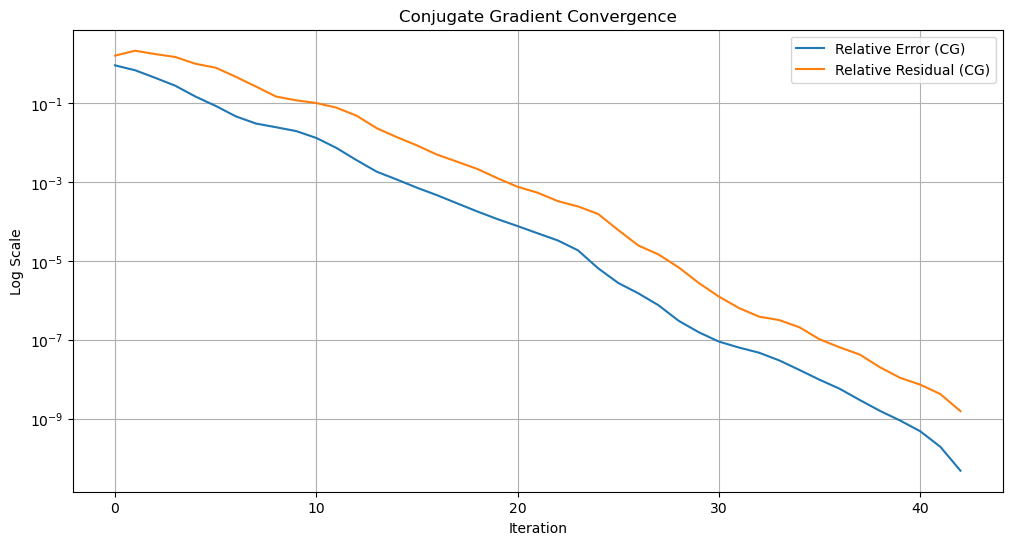

/tmp/ipykernel_825667/4112275491.py:55: DeprecationWarning: scipy.sparse.linalg.gmres called without specifying `callback_type`. The default value will be changed in a future release. For compatibility, specify a value for `callback_type` explicitly, e.g., ``gmres(..., callback_type='pr_norm')``, or to retain the old behavior ``gmres(..., callback_type='legacy')``
  xk = gmres(B, b, tol=tol, callback=callback)
/tmp/ipykernel_825667/4112275491.py:55: DeprecationWarning: 'scipy.sparse.linalg.gmres' keyword argument `tol` is deprecated in favor of `rtol` and will be removed in SciPy v1.14.0. Until then, if set, it will override `rtol`.
  xk = gmres(B, b, tol=tol, callback=callback)


NameError: cannot access free variable 'xk' where it is not associated with a value in enclosing scope

In [86]:
d = 10  # 可以根据需要调整矩阵大小
n = d ** 2
B = spsp.diags(
    diagonals=[
        [4.] * n,
        [-1.] * (n - 1),
        [-1.] * (n - 1),
        [-1.] * (n - d),
        [-1.] * (n - d)
    ],
    offsets=[0, 1, -1, d, -d],
    shape=(n, n),
    format='csr'
)

# 生成右端项和精确解：

from scipy.sparse.linalg import spsolve

b = np.random.rand(n)
xexact = spsolve(B, b)

# 运行共轭梯度算法：
x_cg, errors_cg, residuals_cg = gradient_conjugue(B, b, xexact, max_iter=1000, tol=1e-8)

# 绘制误差和残差：
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.semilogy(errors_cg, label='Relative Error (CG)')
plt.semilogy(residuals_cg, label='Relative Residual (CG)')
plt.xlabel('Iteration')
plt.ylabel('Log Scale')
plt.title('Conjugate Gradient Convergence')
plt.legend()
plt.grid(True)
plt.show()

# 与 GMRES 方法比较：

# 运行 GMRES 算法：

from scipy.sparse.linalg import gmres
import time

# 定义一个函数来记录时间并运行 GMRES
def run_gmres(B, b, xexact, tol=1e-8):
    start_time = time.time()
    callback_info = {'residuals': [], 'errors': []}
    def callback(rk):
        error = np.linalg.norm(xexact - xk[0]) / np.linalg.norm(xexact)
        residual = np.linalg.norm(rk) / np.linalg.norm(b)
        callback_info['errors'].append(error)
        callback_info['residuals'].append(residual)
    xk = gmres(B, b, tol=tol, callback=callback)
    end_time = time.time()
    return xk[0], callback_info['errors'], callback_info['residuals'], end_time - start_time

x_gmres, errors_gmres, residuals_gmres, time_gmres = run_gmres(B, b, xexact)

# 运行时间比较：
# 共轭梯度法时间
start_time_cg = time.time()
x_cg, errors_cg, residuals_cg = gradient_conjugue(B, b, xexact, max_iter=1000, tol=1e-8)
end_time_cg = time.time()
time_cg = end_time_cg - start_time_cg

print(f"Conjugate Gradient time: {time_cg:.4f} seconds")
print(f"GMRES time: {time_gmres:.4f} seconds")

# 绘制比较图：
plt.figure(figsize=(12,6))
plt.semilogy(errors_cg, label='Relative Error (CG)')
plt.semilogy(residuals_cg, label='Relative Residual (CG)')
plt.semilogy(errors_gmres, label='Relative Error (GMRES)', linestyle='--')
plt.semilogy(residuals_gmres, label='Relative Residual (GMRES)', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Log Scale')
plt.title('Convergence Comparison: CG vs GMRES')
plt.legend()
plt.grid(True)
plt.show()

## Partie 3. (Préconditionnement)

7. 

8. 

9. 

10. 